In [4]:
import import_ipynb
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import glob
import pandas as pd
import torchvision
import torch.utils.data as data
from torchvision.transforms.functional import to_pil_image
import torch.utils.data as data
import torch.nn as nn

## Model import

In [5]:
import pretrained_Vgg11_FCN as Vgg11_FCN

importing Jupyter notebook from pretrained_Vgg11_FCN.ipynb
Using device cuda


In [6]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [7]:
pre_trained_model = models.vgg11(pretrained=True).features.to(device)

In [8]:
# for param in pre_trained_model.children():
#     count = count_1
#     if count < 8 :
#         param.requires_grad = False
#     else :
#         param.requires_grad = True

In [9]:
for param in pre_trained_model.children():
     param.requires_grad_(False)

In [10]:
model = Vgg11_FCN.Vgg11Fcn(pre_trained_model, 150).to(device)

In [11]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

pre_trained_model.0.weight 	 torch.Size([64, 3, 3, 3])
pre_trained_model.0.bias 	 torch.Size([64])
pre_trained_model.3.weight 	 torch.Size([128, 64, 3, 3])
pre_trained_model.3.bias 	 torch.Size([128])
pre_trained_model.6.weight 	 torch.Size([256, 128, 3, 3])
pre_trained_model.6.bias 	 torch.Size([256])
pre_trained_model.8.weight 	 torch.Size([256, 256, 3, 3])
pre_trained_model.8.bias 	 torch.Size([256])
pre_trained_model.11.weight 	 torch.Size([512, 256, 3, 3])
pre_trained_model.11.bias 	 torch.Size([512])
pre_trained_model.13.weight 	 torch.Size([512, 512, 3, 3])
pre_trained_model.13.bias 	 torch.Size([512])
pre_trained_model.16.weight 	 torch.Size([512, 512, 3, 3])
pre_trained_model.16.bias 	 torch.Size([512])
pre_trained_model.18.weight 	 torch.Size([512, 512, 3, 3])
pre_trained_model.18.bias 	 torch.Size([512])
conv1.0.weight 	 torch.Size([4096, 128, 1, 1])
conv1.0.bias 	 torch.Size([4096])
conv2.0.weight 	 torch.Size([4096, 1024, 1, 1])
conv2.0.bias 	 torch.Size([4096])
upconvX2.0

In [11]:
from torchinfo import summary
summary(model, (1,3,149,199))

Layer (type:depth-idx)                   Output Shape              Param #
Vgg11Fcn                                 --                        --
├─Sequential: 1                          --                        --
│    └─Conv2d: 2-1                       [1, 64, 149, 199]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 149, 199]         --
│    └─MaxPool2d: 2-3                    [1, 64, 74, 99]           --
│    └─Conv2d: 2-4                       [1, 128, 74, 99]          (73,856)
│    └─ReLU: 2-5                         [1, 128, 74, 99]          --
│    └─MaxPool2d: 2-6                    [1, 128, 37, 49]          --
│    └─Conv2d: 2-7                       [1, 256, 37, 49]          (295,168)
│    └─ReLU: 2-8                         [1, 256, 37, 49]          --
│    └─Conv2d: 2-9                       [1, 256, 37, 49]          (590,080)
│    └─ReLU: 2-10                        [1, 256, 37, 49]          --
│    └─MaxPool2d: 2-11                   [1, 256, 18, 24]   

In [46]:
model.state_dict().keys()

odict_keys(['pre_trained_model.0.weight', 'pre_trained_model.0.bias', 'pre_trained_model.3.weight', 'pre_trained_model.3.bias', 'pre_trained_model.6.weight', 'pre_trained_model.6.bias', 'pre_trained_model.8.weight', 'pre_trained_model.8.bias', 'pre_trained_model.11.weight', 'pre_trained_model.11.bias', 'pre_trained_model.13.weight', 'pre_trained_model.13.bias', 'pre_trained_model.16.weight', 'pre_trained_model.16.bias', 'pre_trained_model.18.weight', 'pre_trained_model.18.bias', 'conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'upconvX2.0.weight', 'upconvX2.0.bias', 'upconvX2.2.weight', 'upconvX2.2.bias', 'upconvX2.2.running_mean', 'upconvX2.2.running_var', 'upconvX2.2.num_batches_tracked', 'upconvX8.0.weight', 'upconvX8.0.bias', 'upconvX8.2.weight', 'upconvX8.2.bias', 'upconvX8.2.running_mean', 'upconvX8.2.running_var', 'upconvX8.2.num_batches_tracked'])

In [9]:
s1 = torch.rand(1,3, 256, 129).to(device)

In [10]:
model(s1).shape

torch.Size([1, 150, 256, 129])

## DataLoad

In [14]:
image_dir = 'images/'
annotation_dir = 'annotations_instance/'   ####25 class

In [15]:
def train_image():
    arr = []
    with open(image_dir + 'training.txt', 'r') as file :
        for i in file.readlines():
            arr.append(image_dir + i[:-1])
    return arr

def validation_image():
    arr = []
    with open(image_dir + 'validation.txt', 'r') as file :
        for i in file.readlines():
            arr.append(image_dir + i[:-1])
    return arr

def train_annotation():
    arr = []
    with open(image_dir + 'training.txt', 'r') as file :
        for i in file.readlines():
            arr.append(annotation_dir + i[:-4] + 'png')
    return arr

def validation_annotation():
    arr = []
    with open(image_dir + 'validation.txt', 'r') as file :
        for i in file.readlines():
            arr.append(annotation_dir + i[:-4] + 'png')
    return arr


In [16]:
train_image = train_image()
validation_image = validation_image()
train_annotation = train_annotation()
validation_annotation = validation_annotation()

In [17]:
def test_image():
    test_list = 'release_test/list.txt'
    test_image= 'release_test/testing/'
    arr = []
    with open(test_list, 'r' ) as file:
        for i in file.readlines():
            arr.append(test_image+ i[:-1])
    return arr

In [18]:
test_image = test_image()

In [19]:
#test_image

## ..

label = Image.open(train_annotation[1])

## Dataload

In [22]:
class AED20k_dataset(data.Dataset):
    def __init__(self, dataset):
        super(AED20k_dataset, self).__init__()
        if dataset == 'train' :
            self.annotation = train_annotation
            self.image = train_image
        elif dataset == 'validation' :
            self.annotation = validation_annotation
            self.image = validation_image
    
    def img_preprocessing(self, x):
        img_preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

        return img_preprocess(x)        
  
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = idx.tolist()       
        
        image = self.image[index]
        image = Image.open(image).convert("RGB")    ### 0.~1. 사이의 torch.float32
        ## image = torchvision.io.read_image(image)
        image = self.img_preprocessing(image)
        #if image.shape[0] != 3:
            
        
        #assert image.shape[0] = 3 , "input_image channel is not 3"
            
            
        
        annotation = self.annotation[index]
        annotation = torchvision.io.read_image(annotation)
        annotation = annotation[0]  ###dtype=torch.uint8    0~255
        
        
        return image, annotation
        ##image.shape (chaennel = 3, H, W)
        ##annotation.shape (H,W)
        
    def __len__(self):
        return len(self.image)

In [23]:
train_dataset = AED20k_dataset("train")
validation_datatset = AED20k_dataset("validation")

## Train

#### Early stopping

In [50]:
import os
PATH = os.getcwd()
model_save_path=  (PATH+ '/'+'FCNcheckpoint.pt')

In [51]:
train_dataloader = data.DataLoader(train_dataset,batch_size=1, shuffle = True)

In [52]:
validation_dataloader = data.DataLoader(validation_datatset,batch_size=1, shuffle = True)

In [53]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model,path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

### Train

In [54]:
#### epoch 마다 모델 저장
#### lr schduler +++ early stopping 적용 --> validation loss 늘어나면 저장, 
#### loss : one-hot label 과 model output값 1:1 지정 
#### return 값 : H, W값


In [55]:
#total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [56]:
#total_params

In [106]:
n_epochs=10
optimizer=torch.optim.Adam(model.parameters(), lr = 1e-4 )
criterion = nn.BCELoss(reduce='mean') #nn.BCEWithLogitsLoss

In [58]:
from tqdm import tqdm

In [59]:
def one_hot(label, num_class):
    label =label.type(torch.int64)
    shape = label.shape  ### (b,h,w)
    tensor = torch.zeros((shape[0], num_class) + shape[1:]).to(device) ####(num_class,h,w)
    one_hot_tensor = tensor.scatter_(1, label.unsqueeze(1), 1.0)   ###(b,n,h,w)
    return one_hot_tensor.to(device)
####label = (bn, H, W)  ----one_hot--> (bn, num_class, H, W)

In [114]:
def train_model(model, patience, n_epochs):
    #### multi GPU
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    #early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, n_epochs + 1):
        path=os.getcwd()+'/'+'FCNcheckpoint_BCELoss{}.pt'.format(epoch)
        model.train() 
        for (data, label) in tqdm(train_dataloader, leave=False):
            optimizer.zero_grad() 
            
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            one_hot_label = one_hot(label, num_class= 150)
            loss = criterion(output, one_hot_label)
            #loss_ = torch.sum(output * one_hot_label, dim=1)
            #loss_ = torch.sum(one_hot_label*one_hot_label, dim=1) - torch.sum(output * one_hot_label, dim=1)
            #loss = torch.mean(loss_)  #loss - 정확도..????? loss 클수록 좋아짐
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            del output, label
            gc.collect()
            torch.cuda.empty_cache()


        model.eval()
        for (data ,label) in tqdm(validation_dataloader, leave=False) :          
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            one_hot_label = one_hot(label, num_class= 150)
            loss = criterion(output, one_hot_label)
            #loss_ = torch.sum(one_hot_label*one_hot_label, dim=1) - torch.sum(output * one_hot_label, dim=1)
            #loss = torch.mean(loss_)
            
            valid_losses.append(loss.item())
            del output, label
            torch.cuda.empty_cache()


        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))
        

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        gc.collect()
        torch.cuda.empty_cache()
        print(print_msg)

        train_losses = []
        valid_losses = []
        torch.save(model.state_dict(), path)
        print("save model stat_dic, epoch : {}".format(epoch))
        #early_stopping(valid_loss, model, path)

#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

    model.load_state_dict(torch.load(path))

    return  model, avg_train_losses, avg_valid_losses

In [115]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [118]:
from tqdm.auto import tqdm
train_model(model, 5, 10)

[ 1/10] train_loss: 0.22550 valid_loss: 0.21404
save model stat_dic, epoch : 1


[ 2/10] train_loss: 0.19859 valid_loss: 0.19150
save model stat_dic, epoch : 2


[ 3/10] train_loss: 0.17076 valid_loss: 0.15284
save model stat_dic, epoch : 3


[ 4/10] train_loss: 0.13486 valid_loss: 0.13477
save model stat_dic, epoch : 4


[ 5/10] train_loss: 0.12631 valid_loss: 0.12417
save model stat_dic, epoch : 5


[ 6/10] train_loss: 0.11394 valid_loss: 0.11176
save model stat_dic, epoch : 6


[ 7/10] train_loss: 0.11047 valid_loss: 0.11350
save model stat_dic, epoch : 7


[ 8/10] train_loss: 0.11023 valid_loss: 0.10289
save model stat_dic, epoch : 8


[ 9/10] train_loss: 0.09607 valid_loss: 0.08179
save model stat_dic, epoch : 9


[10/10] train_loss: 0.07978 valid_loss: 0.08146
save model stat_dic, epoch : 10


(Vgg11Fcn(
   (pre_trained_model): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (12): ReLU(inplace=True)
     (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (14): ReLU(inplace=True)
     (15): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
### 다시 train_model 하면 initialize???

In [ ]:
# # # 2153

## Model load, test

= pre_trained_model.0.weight ==> "module.pre_trained_model.0.weight 로 저장되서 unmatch

In [3]:
path = 'FCNcheckpoint_BCELoss9.pt'

In [12]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [30]:
class model_test():
    def __init__(self, test_dataset):
        self.dataset = test_dataset
            
    def img_preprocessing(self, x):
        img_preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        return img_preprocess(x)     

    def model_pred_img(self, index):
        img = self.dataset[index]
        img = Image.open(img).convert("RGB") 
        x = self.img_preprocessing(img)
        x = x.unsqueeze(0).to(device)
        pred = model(x) ##(1, 150, H, W)
        pred_label = torch.argmax(pred, dim=1) ###(1,H,W)
        plt.imshow(img)
        plt.show()
        plt.imshow(pred_label.cpu().squeeze())
        plt.show()
        #return img, pred_label
    

    

In [31]:
model_test = model_test(test_image)

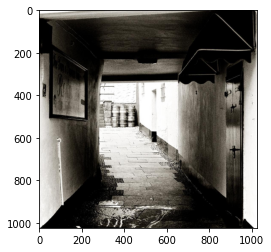

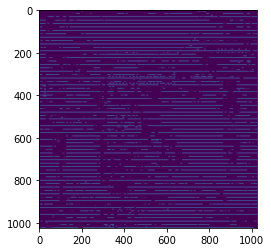

In [36]:
model_test.model_pred_img(17)
